In [10]:
# Block 1: 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 机器学习核心库
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", palette="muted")
plt.rcParams['axes.unicode_minus'] = False 

print("Block 1: 库导入完成！")

Block 1: 库导入完成！


In [11]:
# Block 2: 数据加载与特征工程 (Feature Engineering)
import os

file_path = r"./data/WA_Fn-UseC_-HR-Employee-Attrition.csv" 

if not os.path.exists(file_path):
    print(f"错误：找不到文件，请检查路径: {file_path}")
else:
    df = pd.read_csv(file_path)
    print(f"数据加载成功，原始形状: {df.shape}")

    # 1. 平均每份工作的时间 (AvgTenure): 识别频繁跳槽者
    # 分母加1是为了防止除以0
    df['AvgTenure'] = df['TotalWorkingYears'] / (df['NumCompaniesWorked'] + 1)

    # 2. 职业/年龄比 (CareerAgeRatio): 衡量入行早晚或职业密度
    df['CareerAgeRatio'] = df['TotalWorkingYears'] / df['Age']

    # 3. 忠诚度 (TenureRatio): 在当前公司的年限占总工龄的比例
    df['TenureRatio'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 1)

    # 4. 晋升停滞感 (PromotionStagnation): 在当前岗位待的时间 / 上次晋升到现在的时间
    # 如果数值很大，说明很久没晋升了，容易离职
    df['PromotionStagnation'] = df['YearsInCurrentRole'] / (df['YearsSinceLastPromotion'] + 1)

    # 5. 年龄薪资比 (IncomePerAge): 衡量薪资在同龄人中的竞争力
    df['IncomePerAge'] = df['MonthlyIncome'] / df['Age']

    print("特征工程完成！")

数据加载成功，原始形状: (1470, 35)
特征工程完成！


In [12]:
# Block 3: 数据清洗与切分
# 1. 删除无用特征
drop_cols = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
df.drop(drop_cols, axis=1, inplace=True)

# 2. 标签编码 (Yes -> 1, No -> 0)
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3. One-Hot 编码 (处理部门、职位等文本特征)
df = pd.get_dummies(df, drop_first=True)

# 4. 划分 X 和 y
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# 5. 切分训练集与测试集 (Stratify保证离职率分布一致)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"训练集维度: {X_train.shape}")
print(f"测试集维度: {X_test.shape}")
print("Block 3: 数据准备就绪。")

训练集维度: (1176, 49)
测试集维度: (294, 49)
Block 3: 数据准备就绪。


In [13]:
# Block 4: 微调 CatBoost (寻找黄金平衡点)

# 重新计算基准比例
neg, pos = np.bincount(y_train)
base_ratio = neg / pos
print(f"数据原本的负正比例: {base_ratio:.2f}") # 通常在 5.0 左右

clf = CatBoostClassifier(
    iterations=600,          # 稍微增加一点树的数量
    learning_rate=0.04,      # 稍微降低学习率，让它学得更细致
    depth=6,
    l2_leaf_reg=5,           # 保持正则化，防止误报反弹
    
    scale_pos_weight=4.2,      
    
    loss_function='Logloss',
    verbose=0,
    allow_writing_files=False,
    random_state=42
)

print("Block 4: CatBoost 参数微调完成 (目标：Recall 回升到 0.6+，Precision 保持 0.5)")

数据原本的负正比例: 5.19
Block 4: CatBoost 参数微调完成 (目标：Recall 回升到 0.6+，Precision 保持 0.5)


In [14]:
# Block 5: 训练模型
print("开始训练 CatBoost...")

clf.fit(X_train, y_train)

best_model = clf 

print("\n训练结束！")
print(f"训练集上的准确率: {best_model.score(X_train, y_train):.4f}")

开始训练 CatBoost...

训练结束！
训练集上的准确率: 1.0000


In [15]:
# Block 6: 微调决策阈值

# 1. 拿到预测概率
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 2. 遍历阈值寻找最佳点
thresholds = np.arange(0.2, 0.8, 0.01)
f1_scores = []

for t in thresholds:
    pred_temp = (y_pred_proba > t).astype(int)
    f1_scores.append(f1_score(y_test, pred_temp))

# 3. 获取最佳阈值
best_thresh_index = np.argmax(f1_scores)
best_thresh = thresholds[best_thresh_index]
best_f1_val = f1_scores[best_thresh_index]

print(f"最佳截断阈值: {best_thresh:.2f}")
print(f"对应的 F1 Score: {best_f1_val:.4f}")

最佳截断阈值: 0.28
对应的 F1 Score: 0.5102



--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       247
           1       0.49      0.53      0.51        47

    accuracy                           0.84       294
   macro avg       0.70      0.71      0.71       294
weighted avg       0.84      0.84      0.84       294



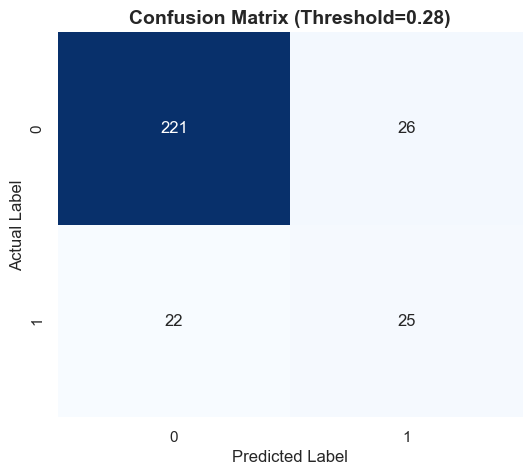

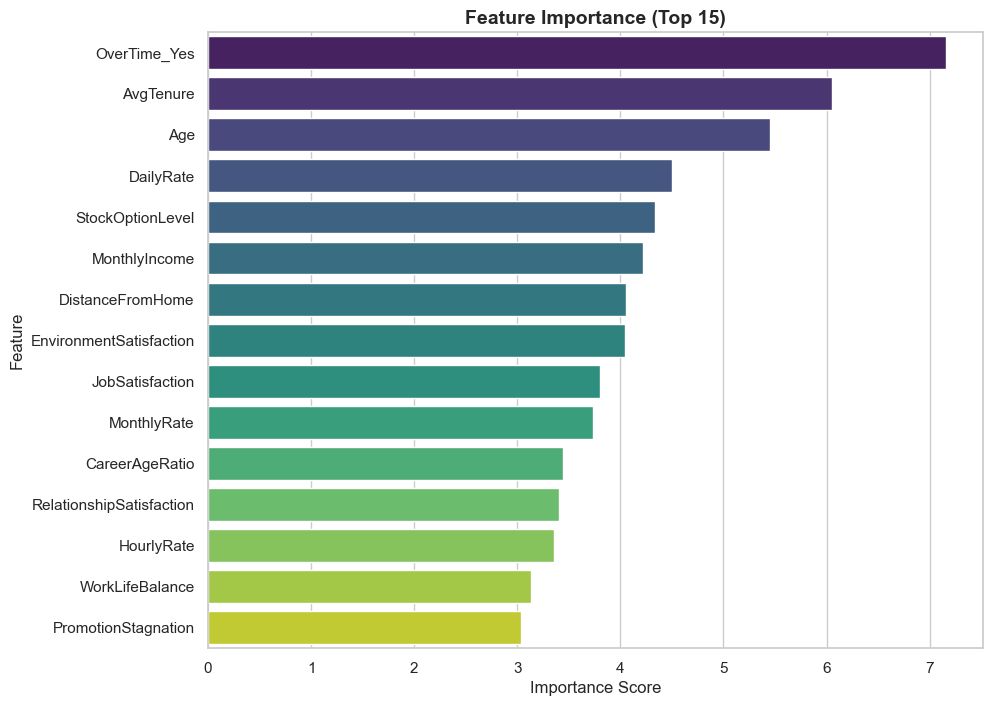

In [16]:
# Block 7: 最终可视化

# 使用最佳阈值生成最终预测结果
y_pred_final = (y_pred_proba > best_thresh).astype(int)

# 1. 打印详细报告
print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred_final))

# 2. 绘制混淆矩阵
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold={best_thresh:.2f})', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. 绘制特征重要性 (验证新特征是否有效)
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': best_model.feature_importances_})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(y='Feature', x='Importance', data=feat_imp, palette='viridis')
plt.title("Feature Importance (Top 15)", fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.show()

正在生成 SHAP 摘要图...


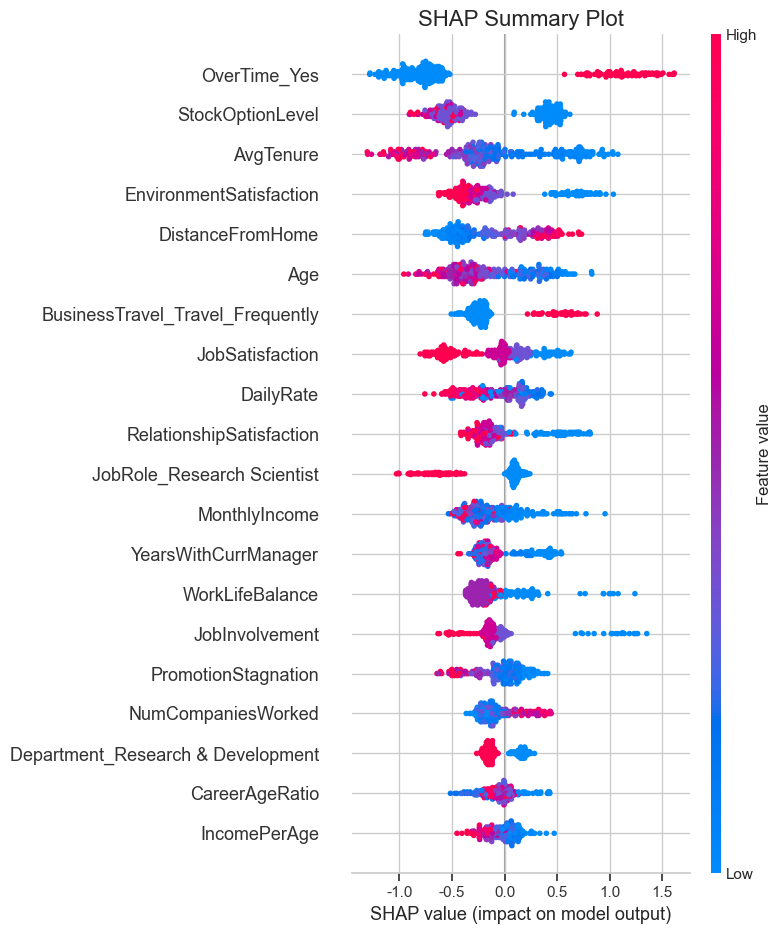

In [17]:
# Block 9: SHAP 深度可解释性分析
import shap

# 1. 初始化解释器
explainer = shap.TreeExplainer(best_model) # 使用之前的最佳 XGBoost 模型
shap_values = explainer.shap_values(X_test)

# 2. 绘制 Summary Plot (最经典的一张图)
print("正在生成 SHAP 摘要图...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot", fontsize=16)
plt.tight_layout()
plt.show()

# 3. 怎么看这张图？(写进报告)
# - 每一行是一个特征
# - 每一个点是一个样本（员工）
# - 红色代表该特征数值高，蓝色代表低
# - 点在右边代表“增加了离职概率”，在左边代表“降低了离职概率”

In [18]:
# Block 10: 模型保存与业务落地
import os

save_folder = r"./save" 

# 如果文件夹不存在,自动创建
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    print(f"已自动创建文件夹: {save_folder}")

# ==============================================================================
# 2. 保存模型文件 (.cbm 格式)
# ==============================================================================
model_filename = "final_catboost_model.cbm"
full_model_path = os.path.join(save_folder, model_filename)

best_model.save_model(full_model_path)
print(f"模型已保存至: {full_model_path}")

# ==============================================================================
# 3. 生成并保存“高风险名单” (.csv 格式)
# ==============================================================================
# 复制一份测试集，避免修改原数据
X_risk = X_test.copy()

# 计算离职概率 (0~1 之间的数)
X_risk['离职概率'] = best_model.predict_proba(X_test)[:, 1]

# 预测结果 (0 或 1)
X_risk['预测状态'] = best_model.predict(X_test)

# 筛选出：预测会离职(1) 且 概率大于 0.5 的员工，按风险从高到低排序
high_risk_list = X_risk[X_risk['预测状态'] == 1].sort_values('离职概率', ascending=False)

# 只保留几个关键列给 HR 看
cols_to_show = ['离职概率', 'OverTime_Yes', 'MonthlyIncome', 'AvgTenure', 'Age', 'StockOptionLevel']
cols_final = [c for c in cols_to_show if c in high_risk_list.columns]

final_report = high_risk_list[cols_final]

# 保存为 CSV 文件 (Excel 可打开)
csv_filename = "High_Risk_Employees.csv"
full_csv_path = os.path.join(save_folder, csv_filename)

# encoding='utf_8_sig' 是为了防止 Excel 打开中文乱码
final_report.to_csv(full_csv_path, index=True, encoding='utf_8_sig')

print(f"高风险名单已导出至: {full_csv_path}")
print("\n--- 名单预览 (Top 5) ---")
print(final_report.head(5))

模型已保存至: ./save\final_catboost_model.cbm
高风险名单已导出至: ./save\High_Risk_Employees.csv

--- 名单预览 (Top 5) ---
          离职概率  OverTime_Yes  MonthlyIncome  AvgTenure  Age  StockOptionLevel
911   0.999199          True           1118   0.500000   25                 0
688   0.997839          True           2121   0.500000   19                 0
357   0.986222          True           2174   1.500000   21                 0
711   0.958377          True           2404   0.428571   29                 0
1402  0.947784          True           1129   0.500000   31                 3
